# Exercise E7-5: Non-Linear Regression by KNN

## Step 0: Introduction to the Theory

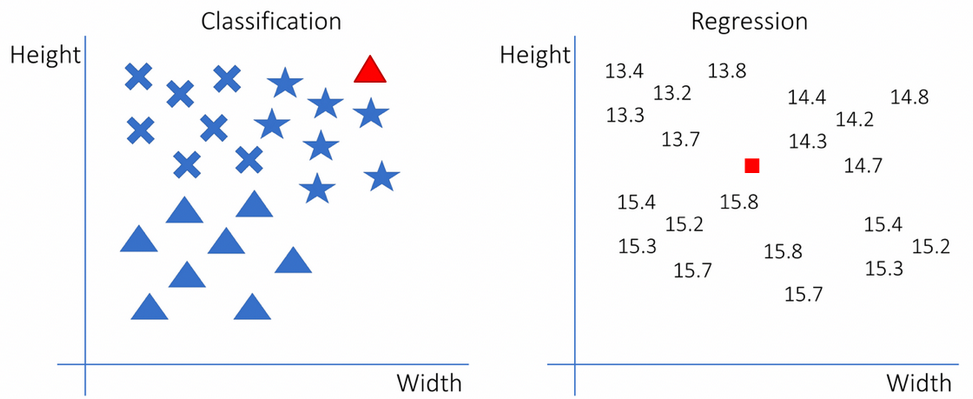

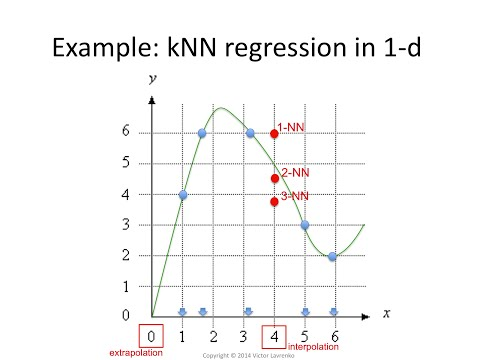

In [1]:
# Embed a video
from IPython.display import Video, Audio, Image, YouTubeVideo

# reference to youtube video
id = '3lp5CmSwrHI'

YouTubeVideo(id=id, width=600, height=300)

### Task
Create a supervised ML model for predicting the age of an abalone from other measurable parameters applying the KNN method.<br>
Abalones are small sea snails that look a bit like mussels. 
We take use of the knowledge that the age matches to the number of rings seen in the shell. By training our model, we can avoid cutting the shell and calculating the age without killing the living abalone.


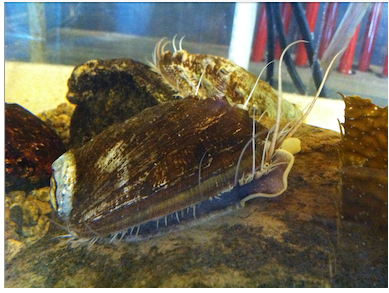 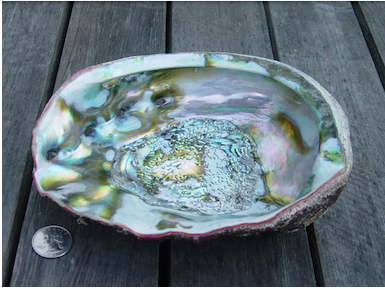

Images from<br>
up: By Sharktopus - Own work, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=14082271 <br>
down: CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=203608

## Step 1: Development Environment

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics as sm

from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Get acquainted with this huge data repository: https://archive.ics.uci.edu/ml/datasets.php. <br>
From there find, read about, and download the data source Abalone https://archive.ics.uci.edu/ml/datasets/Abalone.<br>
Rename your local version of the data file to abalone.csv and then use it for the example below.

In [3]:
# Load data
abalone = pd.read_csv("abalone.csv", header=None,
                     names=['Sex', 'Length', 'Diam', 'Heigh','Whole', 'Shucke', 'Viscera','Shell', 'Rings'])

In [4]:
abalone.shape

(4177, 9)

## Step 2: Data Exploration and preparation

In [5]:
abalone.head()

,Sex,Length,Diam,Heigh,Whole,Shucke,Viscera,Shell,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [7]:
abalone.describe()

,Length,Diam,Heigh,Whole,Shucke,Viscera,Shell,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [8]:
# See the data types
abalone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Sex      4177 non-null   object 
 1   Length   4177 non-null   float64
 2   Diam     4177 non-null   float64
 3   Heigh    4177 non-null   float64
 4   Whole    4177 non-null   float64
 5   Shucke   4177 non-null   float64
 6   Viscera  4177 non-null   float64
 7   Shell    4177 non-null   float64
 8   Rings    4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [10]:
# Check the null values in data
abalone.isnull().sum()

Sex        0
Length     0
Diam       0
Heigh      0
Whole      0
Shucke     0
Viscera    0
Shell      0
Rings      0
dtype: int64

In [11]:
# Remove the column (axis=1) "Sex" as categorical
abalone = abalone.drop("Sex", axis=1)

In [13]:
# See correlation between the features
corr_matrix = abalone.corr()
corr_matrix

,Length,Diam,Heigh,Whole,Shucke,Viscera,Shell,Rings
Length,1.000000,0.986812,0.827554,0.925261,0.897914,0.903018,0.897706,0.556720
Diam,0.986812,1.000000,0.833684,0.925452,0.893162,0.899724,0.905330,0.574660
Heigh,0.827554,0.833684,1.000000,0.819221,0.774972,0.798319,0.817338,0.557467
Whole,0.925261,0.925452,0.819221,1.000000,0.969405,0.966375,0.955355,0.540390
Shucke,0.897914,0.893162,0.774972,0.969405,1.000000,0.931961,0.882617,0.420884
Viscera,0.903018,0.899724,0.798319,0.966375,0.931961,1.000000,0.907656,0.503819
Shell,0.897706,0.905330,0.817338,0.955355,0.882617,0.907656,1.000000,0.627574
Rings,0.556720,0.574660,0.557467,0.540390,0.420884,0.503819,0.627574,1.000000


<AxesSubplot:>

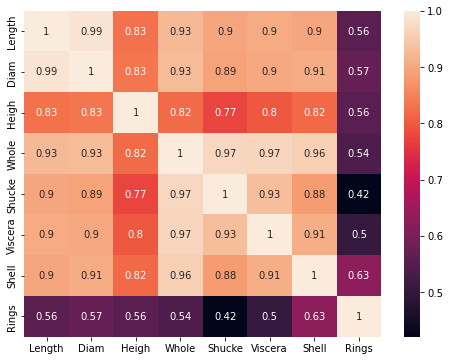

In [15]:
# Plot the matrix as a heat map
plt.subplots(figsize = (8,6))
sns.heatmap(corr_matrix, annot=True)

In [16]:
corr_matrix["Rings"]

Length     0.556720
Diam       0.574660
Heigh      0.557467
Whole      0.540390
Shucke     0.420884
Viscera    0.503819
Shell      0.627574
Rings      1.000000
Name: Rings, dtype: float64

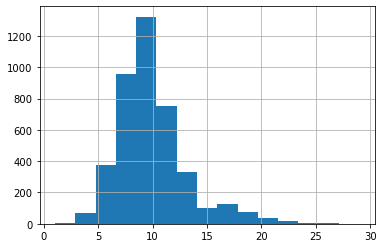

In [17]:
abalone["Rings"].hist(bins=15)
plt.show()

In [24]:
X = abalone.drop("Rings", axis=1)
X = X.values
y = abalone["Rings"]
y = y.values

In [25]:
X.shape

(4177, 7)

In [26]:
y.shape

(4177,)

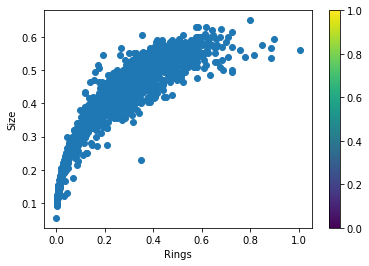

In [31]:
# plot the data
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
plt.xlabel('Rings')
plt.ylabel('Size')

points = ax.scatter(X[:, 6], X[:, 1], cmap=cmap)
#points = axts.scatter(X_test[:,0], X_test[:,1], X_test[:,2], y_test, cmap=cmap)
#points = axtr.scatter(X_train[:,0], X_train[:,1], X_train[:,2], y_train, cmap=cmap)
f.colorbar(points)

plt.show()

In [34]:
#ax.plot(x, y_fit, '-')

## Step 3: Train a Model

In [35]:
k = 5

### Use numpy

In [36]:
# add a new observation
new_data_point = np.array([0.569552, 0.446407, 0.154437, 1.016849, 0.439051, 0.222526, 0.291208])

In [38]:
# Find the distance from it to all training points
distance = np.linalg.norm(X - new_data_point, axis = 1)
distance

array([0.59739395, 0.9518455 , 0.40573594, ..., 0.20397872, 0.14342627,
       1.10583307])

In [40]:
# Sort the distance and take the 3 nearest
nearest_3NN = distance.argsort()[:k]
nearest_3NN

array([4045, 1902, 1644, 1132, 1894], dtype=int64)

In [41]:
# Get their rings
nearest_ring = y[nearest_3NN]
nearest_ring

array([ 9, 11, 10,  9, 11], dtype=int64)

In [42]:
# Take their mean as a prediction for the rings of the new data point
prediction = nearest_ring.mean()
prediction

10.0

### Use scikit-learn

In [43]:
# Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# You can add random_state=1 as a tool for always reproducing the same split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [44]:
X_train

array([[0.455 , 0.35  , 0.12  , ..., 0.1815, 0.144 , 0.16  ],
       [0.255 , 0.195 , 0.055 , ..., 0.0285, 0.017 , 0.021 ],
       [0.52  , 0.41  , 0.11  , ..., 0.2165, 0.0915, 0.184 ],
       ...,
       [0.32  , 0.24  , 0.09  , ..., 0.07  , 0.0265, 0.0425],
       [0.525 , 0.41  , 0.115 , ..., 0.416 , 0.163 , 0.18  ],
       [0.295 , 0.225 , 0.08  , ..., 0.0485, 0.032 , 0.04  ]])

In [45]:
X_train.shape

(3341, 7)

In [47]:
y_train

array([11,  4,  8, ...,  5,  7,  9], dtype=int64)

In [48]:
# Create an instance of the KNN regression model for output experiment
knn_model = KNeighborsRegressor(n_neighbors=k)

In [49]:
# Fit the model to our train data
knn_model.fit(X_train, y_train)

KNeighborsRegressor()

In [51]:
X_train[:, 6]

array([0.16  , 0.021 , 0.184 , ..., 0.0425, 0.18  , 0.04  ])

In [52]:
X_train[:, 1]

array([0.35 , 0.195, 0.41 , ..., 0.24 , 0.41 , 0.225])

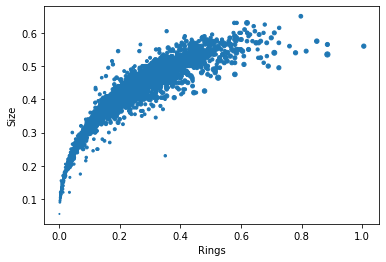

In [50]:
# Plot the train set
plt.xlabel('Rings')
plt.ylabel('Size')

plt.scatter(X_train[:,6], X_train[:,1], y_train)

plt.show()

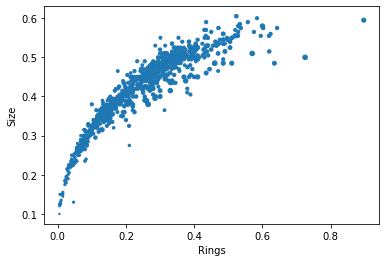

In [54]:
# plot the train set
plt.xlabel('Rings')
plt.ylabel('Size')

plt.scatter(X_test[:,6], X_test[:,1], y_test)

plt.show()

## Step 4: Test the Model

In [55]:
# test it with the test data
y_predicted = knn_model.predict(X_test)

### Estimate the Errors in Prediction

In [56]:
# Mean Absolute Error (MAE) - The mean of the absolute value of the errors
mae = sm.mean_absolute_error(y_test, y_predicted)
mae

1.5686602870813398

In [58]:
# Mean squared Error (MSE) - the mean of the squared errors
mse = sm.mean_squared_error(y_test, y_predicted)
mse

5.056698564593302

In [59]:
# Root Mean Squared Error (RMSE) - the square root of the mean of the squared errors
rmes = sqrt(mse)
rmes

2.248710422574081

In [60]:
# Explain variance score : 1 is perfect predicted
evs = sm.explained_variance_score(y_test, y_predicted)
evs

0.48685572163295077

In [61]:
# R-squared
R2 = sm.r2_score(y_test, y_predicted)
R2

0.48355901008227886

## Step 5: Validation with New Data

In [62]:
# Add new observation
new_data_point = np.array([0.569552, 0.446407, 0.154437, 1.016849, 0.439051, 0.222526, 0.291208]).reshape(1, -1)

In [64]:
# Predict Rings for it
new_rings = knn_model.predict(new_data_point)
new_rings

array([10.4])

## Reference

https://scikit-learn.org/stable/auto_examples/neighbors/plot_regression.html<br>
https://www.saedsayad.com/k_nearest_neighbors_reg.htm <br>
https://realpython.com/knn-python/<br>
https://www.youtube.com/watch?v=3lp5CmSwrHI